In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline

df = pd.read_csv('timeSeries2.csv',thousands=',')
print(df.columns)
df = df.dropna()
print(df.head(3))


year = 2008
band = 'nir'

startYear = year-1
endYear = year+1
startDate = dt.datetime(startYear,1,1)
endDate = dt.datetime(endYear,12,31)

def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi

startDate = convert_date(startDate)
endDate = convert_date(endDate)

t_values = np.linspace(startDate,endDate,1000)




coefficients = {
    'constant': -5038.13916915625,
    'time': 30.406978607177734,
    'cos_1': -1436.0843505859375,
    'cos_2': -235.423095703125,
    'sin_1': 1275.3199462890625,
    'sin_2': -382.04150390625
}

def convert_to_value(date,harmonics,coefficients):
    
    # getting keys for harmonics
    cos_keys = [('cos_'+str(i)) for i in range(1,harmonics+1)]
    sin_keys = [('sin_'+str(i)) for i in range(1,harmonics+1)]
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,harmonics+1)]
    
    sum = 0
    # add constant
    sum += coefficients['constant']
    # add time trend
    sum += coefficients['time']*date
    # add harmonics
    for i in range(harmonics):
        cos_key = cos_keys[i]
        sin_key = sin_keys[i]
        sum += cos_independents[i]*coefficients[cos_keys[i]]
        sum += sin_independents[i]*coefficients[sin_keys[i]]
        
    
    
    return sum

sr_values = [convert_to_value(d,2,coefficients) for d in t_values]
sr_values = [v/10000 for v in sr_values]

t_points = []
sr_points = []
for index, row in df.iterrows():
    d = row['system:time_start']
    d = dt.datetime.strptime(d,'%b %d, %Y')
    t_points.append(convert_date(d))
    sr_points.append(row[band])

sr_points = [v/10000 for v in sr_points]
t_ticks = list(np.linspace(startDate,endDate,endYear-startYear+2))
t_labels = list(np.linspace(startYear,endYear+1,endYear-startYear+2,dtype=np.int32))


plt.rcParams.update({'font.size': 20})
# print(time,cos,sin)
# df['time'] = dt.datetime.strptime(df['system:time_start'],'%b %d, %Y')
datetime_object = dt.datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')
fig, ax = plt.subplots()
plt.plot(t_values,sr_values,'--',color='k',linewidth=1)
plt.scatter(t_points,sr_points,color='k',s=5)
ax.set_xticks(t_ticks)
ax.set_xticklabels(t_labels,fontdict={'fontsize': 20})
plt.ylim([0,0.6])
plt.xlabel('Year',fontweight='bold',fontsize=20)
plt.ylabel('Surface reflectance',fontweight='bold',fontsize=20)
plt.legend(['Harmonic fit','Observations'],frameon=False,prop={'size': 10})
plt.show()




FileNotFoundError: [Errno 2] File b'timeSeries2.csv' does not exist: b'timeSeries2.csv'

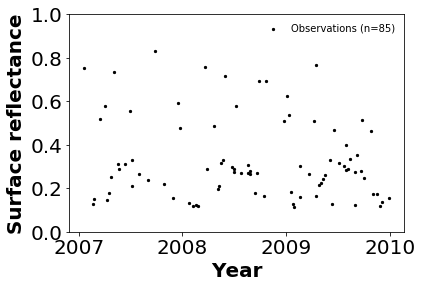

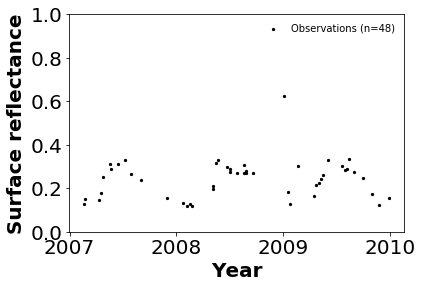

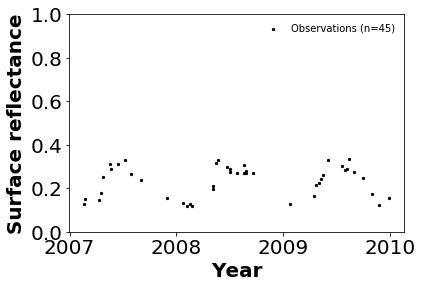

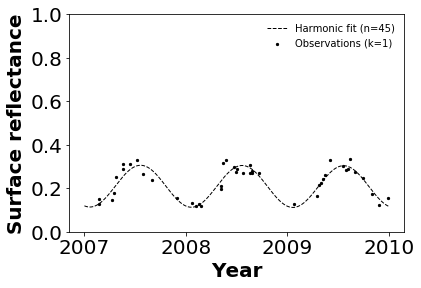

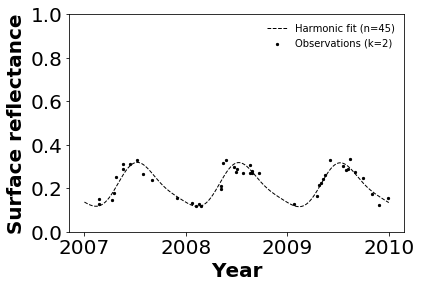

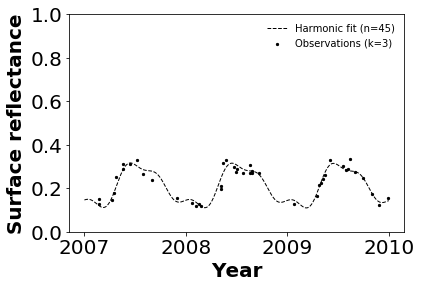

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline

def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi


def convert_to_value(date,harmonics,coefficients):
    
    # getting keys for harmonics
    cos_keys = [('cos_'+str(i)) for i in range(1,harmonics+1)]
    sin_keys = [('sin_'+str(i)) for i in range(1,harmonics+1)]
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,harmonics+1)]
    
    sum = 0
    # add constant
    sum += coefficients['constant']
    # add time trend
    sum += coefficients['time']*date
    # add harmonics
    for i in range(harmonics):
        cos_key = cos_keys[i]
        sin_key = sin_keys[i]
        sum += cos_independents[i]*coefficients[cos_keys[i]]
        sum += sin_independents[i]*coefficients[sin_keys[i]]
        
    return sum



def plot_time_series(data_folder,file_name,output_name,year,band,harmonics=False):
    df = pd.read_csv(data_folder+file_name,thousands=',')
    df = df.dropna()
    startYear = year-1
    endYear = year+1
    startDate = dt.datetime(startYear,1,1)
    endDate = dt.datetime(endYear,12,31)
    startDate = convert_date(startDate)
    endDate = convert_date(endDate)
    t_values = np.linspace(startDate,endDate,1000)
    
    t_points = []
    sr_points = []
    for index, row in df.iterrows():
        d = row['system:time_start']
        d = dt.datetime.strptime(d,'%b %d, %Y')
        t_points.append(convert_date(d))
        sr_points.append(row[band])
        
    sr_points = [v/10000 for v in sr_points]
    t_ticks = list(np.linspace(startDate,endDate,endYear-startYear+2))
    t_labels = list(np.linspace(startYear,endYear+1,endYear-startYear+2,dtype=np.int32))
    
    n_points = len(sr_points)
    n_str = '('+'n='+str(n_points)+')'
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots()
    plt.scatter(t_points,sr_points,color='k',s=5)
    
    if harmonics != False:
        k_harm = harmonics['harmonics']
        k_str = '('+'k='+str(k_harm)+')'
        sr_values = [convert_to_value(d,k_harm,harmonics) for d in t_values]
        sr_values = [v/10000 for v in sr_values]
        plt.plot(t_values,sr_values,'--',color='k',linewidth=1)
        plt.legend(['Harmonic fit '+n_str,'Observations '+k_str],frameon=False,prop={'size': 10})
    else:
        plt.legend(['Observations '+n_str],frameon=False,prop={'size': 10})
    
    ax.set_xticks(t_ticks)
    ax.set_xticklabels(t_labels,fontdict={'fontsize': 20})
    plt.ylim([0,1])
    plt.xlabel('Year',fontweight='bold',fontsize=20)
    plt.ylabel('Surface reflectance',fontweight='bold',fontsize=20)
    plt.savefig(output_name,dpi=300,bbox_inches='tight')
    plt.show()
    
    
    

data_folder = 'C:\\Users\\hafne\\Desktop\\jupyter_notebook\\data_harmonics\\'
data_folder = ''

coefficients3 = {
    'harmonics': 3,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'cos_3': 96.32,
    'sin_1': -319.839,
    'sin_2': -56.05,
    'sin_3': 229.7776
}

coefficients2 = {
    'harmonics': 2,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'sin_1': -319.839,
    'sin_2': -56.05
}

coefficients1 = {
    'harmonics': 1,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'sin_1': -319.839
}
plot_time_series(data_folder,'level0.csv','level0',2008,'nir')
plot_time_series(data_folder,'level2.csv','level2',2008,'nir')
plot_time_series(data_folder,'level3.csv','level3',2008,'nir')
plot_time_series(data_folder,'level3.csv','level3harmonics1',2008,'nir',coefficients1)
plot_time_series(data_folder,'level3.csv','level3harmonics2',2008,'nir',coefficients2)
plot_time_series(data_folder,'level3.csv','level3harmonics3',2008,'nir',coefficients3)








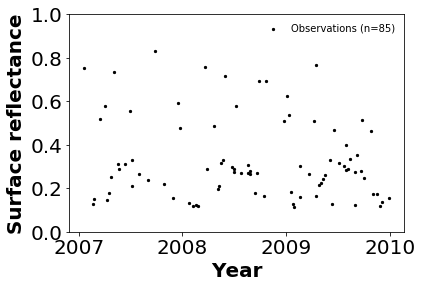

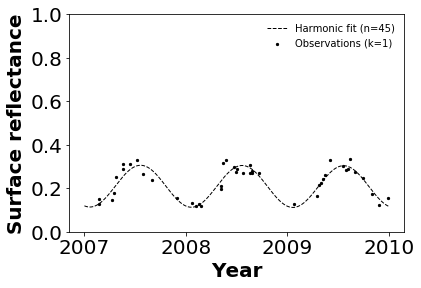

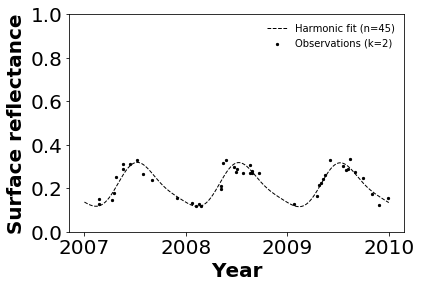

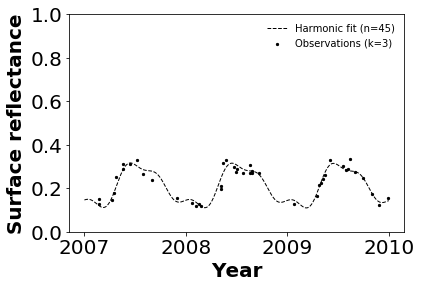

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline

def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi


def convert_to_value(date,harmonics,coefficients):
    
    # getting keys for harmonics
    cos_keys = [('cos_'+str(i)) for i in range(1,harmonics+1)]
    sin_keys = [('sin_'+str(i)) for i in range(1,harmonics+1)]
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,harmonics+1)]
    
    sum = 0
    # add constant
    sum += coefficients['constant']
    # add time trend
    sum += coefficients['time']*date
    # add harmonics
    for i in range(harmonics):
        cos_key = cos_keys[i]
        sin_key = sin_keys[i]
        sum += cos_independents[i]*coefficients[cos_keys[i]]
        sum += sin_independents[i]*coefficients[sin_keys[i]]
        
    return sum



def plot_time_series(data_folder,file_name,output_name,year,band,harmonics=False):
    df = pd.read_csv(data_folder+file_name,thousands=',')
    df = df.dropna()
    startYear = year-1
    endYear = year+1
    startDate = dt.datetime(startYear,1,1)
    endDate = dt.datetime(endYear,12,31)
    startDate = convert_date(startDate)
    endDate = convert_date(endDate)
    t_values = np.linspace(startDate,endDate,1000)
    
    t_points = []
    sr_points = []
    for index, row in df.iterrows():
        d = row['system:time_start']
        d = dt.datetime.strptime(d,'%b %d, %Y')
        t_points.append(convert_date(d))
        sr_points.append(row[band])
        
    sr_points = [v/10000 for v in sr_points]
    t_ticks = list(np.linspace(startDate,endDate,endYear-startYear+2))
    t_labels = list(np.linspace(startYear,endYear+1,endYear-startYear+2,dtype=np.int32))
    
    n_points = len(sr_points)
    n_str = '('+'n='+str(n_points)+')'
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots()
    ax.scatter(t_points,sr_points,color='k',s=5)
    
    if harmonics != False:
        k_harm = harmonics['harmonics']
        k_str = '('+'k='+str(k_harm)+')'
        sr_values = [convert_to_value(d,k_harm,harmonics) for d in t_values]
        sr_values = [v/10000 for v in sr_values]
        ax.plot(t_values,sr_values,'--',color='k',linewidth=1)
        ax.legend(['Harmonic fit '+n_str,'Observations '+k_str],frameon=False,prop={'size': 10})
    else:
        ax.legend(['Observations '+n_str],frameon=False,prop={'size': 10})
    
    ax.set_xticks(t_ticks)
    ax.set_xticklabels(t_labels,fontdict={'fontsize': 20})
    plt.ylim([0,1])
    plt.xlabel('Year',fontweight='bold',fontsize=20)
    plt.ylabel('Surface reflectance',fontweight='bold',fontsize=20)
    plt.savefig(output_name,dpi=300,bbox_inches='tight')
    plt.show()
    
    
    

data_folder = 'D:/thesis/scripts/data/model/'


coefficients3 = {
    'harmonics': 3,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'cos_3': 96.32,
    'sin_1': -319.839,
    'sin_2': -56.05,
    'sin_3': 229.7776
}

coefficients2 = {
    'harmonics': 2,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'sin_1': -319.839,
    'sin_2': -56.05
}

coefficients1 = {
    'harmonics': 1,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'sin_1': -319.839
}






plot_time_series(data_folder,'level0.csv','level0',2008,'nir')
plot_time_series(data_folder,'level3.csv','level3harmonics1',2008,'nir',coefficients1)
plot_time_series(data_folder,'level3.csv','level3harmonics2',2008,'nir',coefficients2)
plot_time_series(data_folder,'level3.csv','level3harmonics3',2008,'nir',coefficients3)



C:\Users\User\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


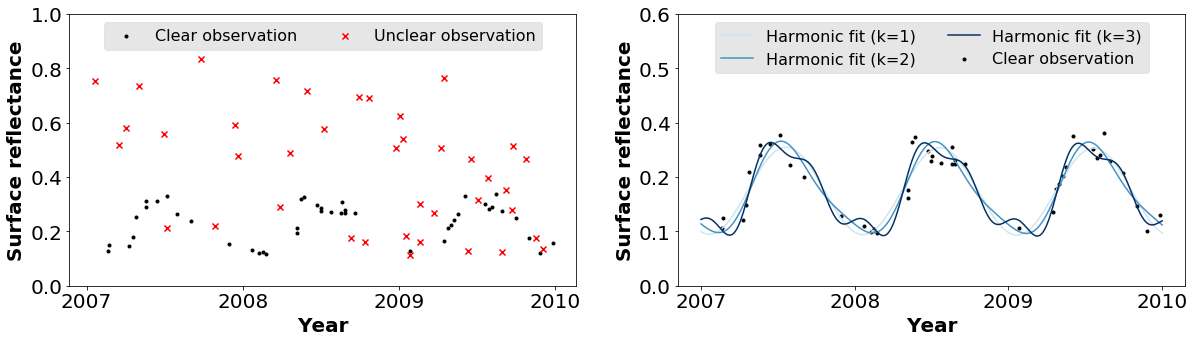

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline


def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi


def convert_to_value(date,harmonics,coefficients):
    
    # getting keys for harmonics
    cos_keys = [('cos_'+str(i)) for i in range(1,harmonics+1)]
    sin_keys = [('sin_'+str(i)) for i in range(1,harmonics+1)]
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,harmonics+1)]
    
    sum = 0
    # add constant
    sum += coefficients['constant']
    # add time trend
    sum += coefficients['time']*date
    # add harmonics
    for i in range(harmonics):
        cos_key = cos_keys[i]
        sin_key = sin_keys[i]
        sum += cos_independents[i]*coefficients[cos_keys[i]]
        sum += sin_independents[i]*coefficients[sin_keys[i]]
        
    return sum


def get_time_components(year):
    
    startYear = year-1
    endYear = year+1
    startDate = dt.datetime(startYear,1,1)
    endDate = dt.datetime(endYear,12,31)
    startDate = convert_date(startDate)
    endDate = convert_date(endDate)
    t_vector = np.linspace(startDate,endDate,1000)
    
    return startDate, startYear, endDate, endYear, t_vector




def plot_sr_data_to_ax(ax,df,year,band,ylimits=(0,1),only_clear=False):
    
    startDate, startYear, endDate, endYear, t_vector = get_time_components(year)
    
    t_ticks = list(np.linspace(startDate,endDate,endYear-startYear+2))
    t_labels = list(np.linspace(startYear,endYear+1,endYear-startYear+2,dtype=np.int32))
    
    n_points = df.shape[0]
    n_str = '('+'n='+str(n_points)+')'
    
    if only_clear:
        df_clear = df[df['clear']==False]
        ax.scatter(df_clear['t'],df_clear[band],marker='.',color='k')
    else:
        df_clear = df[df['clear']==True]
        df_notclear = df[df['clear']==False]
        ax.scatter(df_notclear['t'],df_notclear[band],marker='.',color='k')
        ax.scatter(df_clear['t'],df_clear[band],marker='x',color='r')

    
    ax.set_xticks(t_ticks)
    ax.set_xticklabels(t_labels,fontdict={'fontsize': fontsize})
    ax.set_ylim(ylimits)
    ax.set_yticks([y for y in list(np.linspace(ylimits[0],ylimits[1],6))])
    ax.set_yticklabels([round(y,1) for y in list(np.linspace(ylimits[0],ylimits[1],6))],fontdict={'fontsize': fontsize})
    
    ax.set_xlabel('Year',fontweight='bold',fontsize=fontsize)
    ax.set_ylabel('Surface reflectance',fontweight='bold',fontsize=fontsize)
    
    
def add_harmonics_to_ax(ax,coefficients,year):
    
    _, _, _, _, t_vector = get_time_components(year)
    
    n_harm = coefficients['harmonics']
    n_str = '('+'k='+str(n_harm)+')'
    sr_values = [convert_to_value(d,n_harm,coefficients) for d in t_vector]
    sr_values = [v/10000 for v in sr_values]
    
    # linestyle = '-' if n_harm==3 else '--' if n_harm==2 else ':'
    linestyle = '-' 
    # color = "#0c2c84" if n_harm==3 else "#1d91c0" if n_harm==2 else "#7fcdbb"
    color = "#053061" if n_harm==3 else "#4393c3" if n_harm==2 else "#d1e5f0"
    ax.plot(t_vector,sr_values,linestyle,color=color,linewidth=1.5)
    #ax.legend(['Harmonic fit '+n_str,'Observations '+k_str],frameon=False,prop={'size': 10})
    

data_folder = 'D:/thesis/scripts/data/model/'
year = 2008
band = 'nir'
    



# some preprocessing
df_all = pd.read_csv(f'{data_folder}level0.csv',thousands=',')
df_clear = pd.read_csv(f'{data_folder}level3.csv',thousands=',')

df_all['clear'] = pd.isna(df_clear[band])
df = df_all.dropna()

df['t'] = df['system:time_start'].apply(lambda d : convert_date(dt.datetime.strptime(d,'%b %d, %Y')))
df[band] = df[band]/10000.0
    
coefficients3 = {
    'harmonics': 3,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'cos_3': 96.32,
    'sin_1': -319.839,
    'sin_2': -56.05,
    'sin_3': 229.7776
}

coefficients2 = {
    'harmonics': 2,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'sin_1': -319.839,
    'sin_2': -56.05
}

coefficients1 = {
    'harmonics': 1,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'sin_1': -319.839
}

    
    
fontsize = 20

fig, axs = plt.subplots(1,2, figsize=(20,5), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.ravel()

plot_sr_data_to_ax(axs[0],df,year,band,(0.0,1),False)

axs[0].legend(
    [
        'Clear observation',
        'Unclear observation'
    ],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 16},
    ncol=2,
    loc='upper center'
)

plot_sr_data_to_ax(axs[1],df,year,band,(0.0,0.6),True)
add_harmonics_to_ax(axs[1],coefficients1,year)
add_harmonics_to_ax(axs[1],coefficients2,year)
add_harmonics_to_ax(axs[1],coefficients3,year)

axs[1].legend(
    [
        'Harmonic fit (k=1)',
        'Harmonic fit (k=2)',
        'Harmonic fit (k=3)',
        'Clear observation'
    ],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 16},
    ncol=2,
    loc='upper center'
)


plt.savefig('model.png',dpi=300,bbox_inches='tight')
plt.show()

C:\Users\User\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


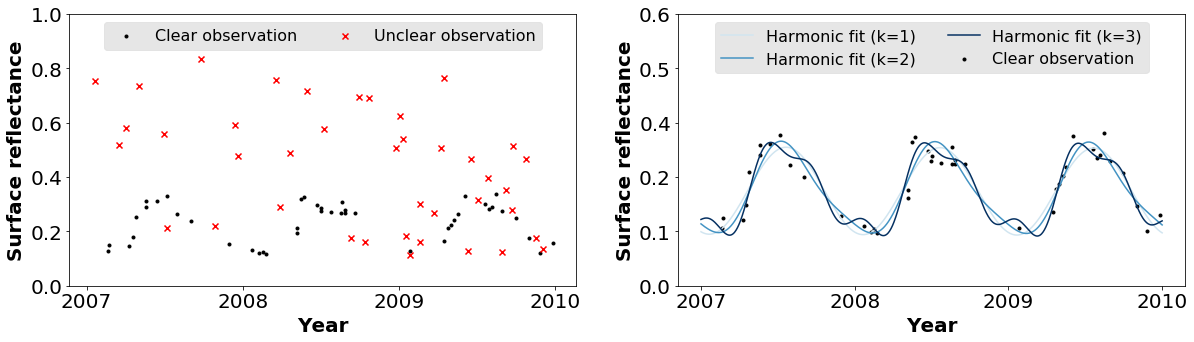

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline


def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi


def convert_to_value(date,harmonics,coefficients):
    
    # getting keys for harmonics
    cos_keys = [('cos_'+str(i)) for i in range(1,harmonics+1)]
    sin_keys = [('sin_'+str(i)) for i in range(1,harmonics+1)]
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,harmonics+1)]
    
    sum = 0
    # add constant
    sum += coefficients['constant']
    # add time trend
    sum += coefficients['time']*date
    # add harmonics
    for i in range(harmonics):
        cos_key = cos_keys[i]
        sin_key = sin_keys[i]
        sum += cos_independents[i]*coefficients[cos_keys[i]]
        sum += sin_independents[i]*coefficients[sin_keys[i]]
        
    return sum


def get_time_components(year):
    
    startYear = year-1
    endYear = year+1
    startDate = dt.datetime(startYear,1,1)
    endDate = dt.datetime(endYear,12,31)
    startDate = convert_date(startDate)
    endDate = convert_date(endDate)
    t_vector = np.linspace(startDate,endDate,1000)
    
    return startDate, startYear, endDate, endYear, t_vector




def plot_sr_data_to_ax(ax,df,year,band,ylimits=(0,1),only_clear=False):
    
    startDate, startYear, endDate, endYear, t_vector = get_time_components(year)
    
    t_ticks = list(np.linspace(startDate,endDate,endYear-startYear+2))
    t_labels = list(np.linspace(startYear,endYear+1,endYear-startYear+2,dtype=np.int32))
    
    n_points = df.shape[0]
    n_str = '('+'n='+str(n_points)+')'
    
    if only_clear:
        df_clear = df[df['clear']==False]
        ax.scatter(df_clear['t'],df_clear[band],marker='.',color='k')
    else:
        df_clear = df[df['clear']==True]
        df_notclear = df[df['clear']==False]
        ax.scatter(df_notclear['t'],df_notclear[band],marker='.',color='k')
        ax.scatter(df_clear['t'],df_clear[band],marker='x',color='r')

    
    ax.set_xticks(t_ticks)
    ax.set_xticklabels(t_labels,fontdict={'fontsize': fontsize})
    ax.set_ylim(ylimits)
    ax.set_yticks([y for y in list(np.linspace(ylimits[0],ylimits[1],6))])
    ax.set_yticklabels([round(y,1) for y in list(np.linspace(ylimits[0],ylimits[1],6))],fontdict={'fontsize': fontsize})
    
    ax.set_xlabel('Year',fontweight='bold',fontsize=fontsize)
    ax.set_ylabel('Surface reflectance',fontweight='bold',fontsize=fontsize)
    
    
def add_harmonics_to_ax(ax,coefficients,year):
    
    _, _, _, _, t_vector = get_time_components(year)
    
    n_harm = coefficients['harmonics']
    n_str = '('+'k='+str(n_harm)+')'
    sr_values = [convert_to_value(d,n_harm,coefficients) for d in t_vector]
    sr_values = [v/10000 for v in sr_values]
    
    # linestyle = '-' if n_harm==3 else '--' if n_harm==2 else ':'
    linestyle = '-' 
    # color = "#0c2c84" if n_harm==3 else "#1d91c0" if n_harm==2 else "#7fcdbb"
    color = "#053061" if n_harm==3 else "#4393c3" if n_harm==2 else "#d1e5f0"
    ax.plot(t_vector,sr_values,linestyle,color=color,linewidth=1.5)
    #ax.legend(['Harmonic fit '+n_str,'Observations '+k_str],frameon=False,prop={'size': 10})
    

data_folder = 'D:/thesis/scripts/data/model/'
year = 2008
band = 'nir'
    



# some preprocessing
df_all = pd.read_csv(f'{data_folder}level0.csv',thousands=',')
df_clear = pd.read_csv(f'{data_folder}level3.csv',thousands=',')

df_all['clear'] = pd.isna(df_clear[band])
df = df_all.dropna()

df['t'] = df['system:time_start'].apply(lambda d : convert_date(dt.datetime.strptime(d,'%b %d, %Y')))
df[band] = df[band]/10000.0
    
coefficients3 = {
    'harmonics': 3,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'cos_3': 96.32,
    'sin_1': -319.839,
    'sin_2': -56.05,
    'sin_3': 229.7776
}

coefficients2 = {
    'harmonics': 2,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'cos_2': 174,
    'sin_1': -319.839,
    'sin_2': -56.05
}

coefficients1 = {
    'harmonics': 1,
    'constant': 2454.386474609,
    'time': -1.515890479,
    'cos_1': -908,
    'sin_1': -319.839
}

    
    
fontsize = 20

fig, axs = plt.subplots(1,2, figsize=(20,5), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.ravel()

plot_sr_data_to_ax(axs[0],df,year,band,(0.0,1),False)

axs[0].legend(
    [
        'Clear observation',
        'Unclear observation'
    ],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 16},
    ncol=2,
    loc='upper center'
)

plot_sr_data_to_ax(axs[1],df,year,band,(0.0,0.6),True)
add_harmonics_to_ax(axs[1],coefficients1,year)
add_harmonics_to_ax(axs[1],coefficients2,year)
add_harmonics_to_ax(axs[1],coefficients3,year)

axs[1].legend(
    [
        'Harmonic fit (k=1)',
        'Harmonic fit (k=2)',
        'Harmonic fit (k=3)',
        'Clear observation'
    ],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 16},
    ncol=2,
    loc='upper center'
)


plt.savefig('model.png',dpi=300,bbox_inches='tight')
plt.show()

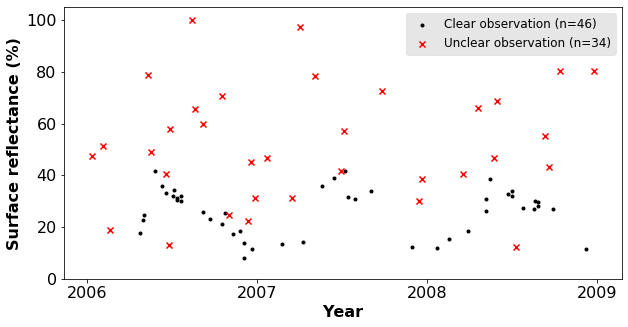

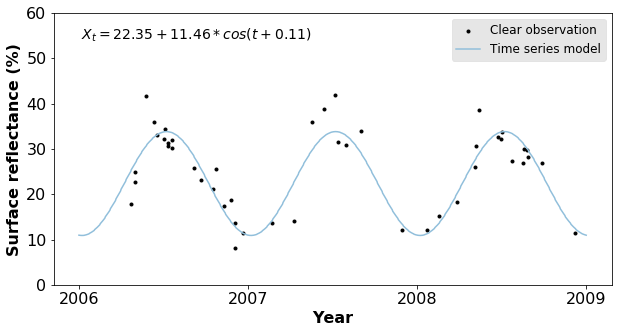

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline





    
data_folder = 'time_series/'
refdate = dt.datetime(1970,1,1)
year = 2007

df_all = pd.read_csv(f'{data_folder}allObservations.csv',thousands=',').drop(['system:index','.geo'],axis=1)
data_all = [df_all[image][0] for image in list(df_all.columns)]

df_clear = pd.read_csv(f'{data_folder}clearObservations.csv',thousands=',').drop(['system:index','.geo'],axis=1)
data_clear = [df_clear[image][0] for image in list(df_clear.columns)]

df_time = pd.read_csv(f'{data_folder}time.csv',thousands=',').drop(['system:index','.geo'],axis=1)
data_time = [df_time[image][0] for image in list(df_time.columns)]

df_coefficients = pd.read_csv(f'{data_folder}coefficients.csv',thousands=',')


time_labels = [year-1,year,year+1,year+2]
time_ticks = [(dt.datetime(year,1,1)-refdate).total_seconds()*1000 for year in time_labels]


x_clear, y_clear, x_unclear, y_unclear = ([],[],[],[])
for i, (a,c,t) in enumerate(zip(data_all,data_clear,data_time)):
    if not math.isnan(a):
        if not math.isnan(c):
            y_clear.append(c)
            x_clear.append(t)
        else:
            a = 10000 if a>10000 else a
            y_unclear.append(a)
            x_unclear.append(t)





time = [refdate+dt.timedelta(milliseconds=timedelta) for timedelta in data_time]


fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 16
plt.rcParams.update({'font.size': fontsize})
        
ax.scatter(x_clear,y_clear,marker='.',color='k')
ax.scatter(x_unclear,y_unclear,marker='x',color='r')

ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels,fontdict={'fontsize': fontsize})

y_ticks = list(np.arange(0,10001,2000))
y_labels = [f'{y_tick/100:.0f}' for y_tick in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

ax.set_ylabel('Surface reflectance (%)',fontsize=fontsize,fontweight='bold')
ax.set_xlabel('Year',fontsize=fontsize,fontweight='bold')

ax.legend(
    [
        f'Clear observation (n={len(x_clear)})',
        f'Unclear observation (n={len(x_unclear)})'
    ],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 12},
    ncol=1,
    loc='upper right'
)


plt.savefig('model_observations.png',dpi=300,box_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 16


x_ticks = list(np.linspace(time_ticks[0],time_ticks[-1],1000))

def date_to_value(timedelta,const,ccos,csin):
    
    date = refdate+dt.timedelta(milliseconds=timedelta)
    diff = (date-refdate).days/365.24
    date = diff*2*math.pi
    
    """
    a = ccos
    b = csin
    amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
    phase_shift = np.arctan(b/a)
    return const + amplitude*math.cos(date+phase_shift)
    """
    return const + ccos*math.cos(date) + csin*math.sin(date)



const = df_coefficients['constant'][0]
ccos = df_coefficients['cos_1'][0]
csin = df_coefficients['sin_1'][0]

y_values = [date_to_value(timedelta,const,ccos,csin) for timedelta in x_ticks]

ax.scatter(x_clear,y_clear,marker='.',color='k',label='Clear observation')
ax.plot(x_ticks,y_values,'-',color='#91bfdb',linewidth=1.5,label='Time series model')

ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels,fontdict={'fontsize': fontsize})

y_ticks = list(np.arange(0,6001,1000))
y_labels = [f'{y_tick/100:.0f}' for y_tick in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

ax.set_ylabel('Surface reflectance (%)',fontsize=fontsize,fontweight='bold')
ax.set_xlabel('Year',fontsize=fontsize,fontweight='bold')


a = ccos
b = csin
amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
phase_shift = np.arctan(b/a)

textstr = '\n'.join((
    r'$c=%.2f$' % (const, ),
    r'$A=%.2f$' % (amplitude, ),
    r'$p=%.2f$' % (phase_shift, )))

textstr = f'$X_t=%.2f+%.2f*cos(t+%.2f)$' % (const/100,amplitude/100,phase_shift)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 12},
    ncol=1,
    loc='upper right'
)

plt.savefig('model_timeseries.png',dpi=300,box_inches='tight')
plt.show()